# Sunlight Regressor
回歸器去預測光照度，而不是發電量

在原本的資料檔中寫入新的一欄 “Sunlight_pred”

In [116]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

## Params

In [65]:
UPPER = 117758.2
DATA_PATH = '../../Dataset/TrainingData_avg'
EPOCHS = 5

## Dataloader

In [144]:
class LightDataloader(Dataset):
    def __init__(self, filename, test_size=0.2, random_state=42):
        self.data = pd.read_csv(filename)
        self.data = self.split_time(self.data)

        # 隔開到達光照最大值的資料，未達最大值者，稱為「真」資料
        self.truth_data = self.data[self.data['Sunlight(Lux)'] != UPPER].reset_index(drop=True)
        self.predict_data = self.data[self.data['Sunlight(Lux)'] == UPPER].reset_index(drop=True)
        self.predict_data = self.predict_data.drop(columns = ['DateTime'])
        
        # 只有不是最大值的資料會用來訓練與測試
        self.train_data, self.test_data = train_test_split(self.truth_data, test_size=test_size, random_state=random_state)
        
        # 訓練集
        self.train_data = self.train_data.drop(columns = ['DateTime'])
        self.X_train = self.train_data.drop(columns=['Sunlight(Lux)']).values
        self.y_train = self.train_data['Sunlight(Lux)'].values

        # 測試集
        self.test_data = self.test_data.drop(columns = ['DateTime'])
        self.X_test = self.test_data.drop(columns=['Sunlight(Lux)']).values
        self.y_test = self.test_data['Sunlight(Lux)'].values
                
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        X = self.X_train[idx]
        y = self.y_train[idx]
        print(X, y)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def split_time(self, df):
        df_day = df["DateTime"].astype(str)
        day = df_day.str[8:10].astype(int)
        month = df_day.str[5:7].astype(int)

        df['year'] = df_day.str[:4].astype(int)
        df['month'] = df_day.str[5:7].astype(int)
        df['day'] = self.count_days(month, day)
        df['hour'] = df_day.str[11:13].astype(int)
        df['minute'] = df_day.str[14:16].astype(int)

        return df
    
    def count_days(self, month, days):
        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        
        days_from_months = pd.Series(month).apply(lambda m: sum(days_in_month[:m - 1]))
        
        total_days = days_from_months + days
    
        return total_days

## 個別訓練
每個檔案訓練一個模型

In [145]:
avg_mae_list = []
avg_mse_list = []
all_true = []
all_pred = []

for filename in os.listdir(DATA_PATH):
# 進入每份檔案（個別發電站個別做回歸）

    # 載入資料
    filepath = os.path.join(DATA_PATH, filename)
    dataset = LightDataloader(filepath)

    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(dataset.X_train, dtype=torch.float32),
            torch.tensor(dataset.y_train, dtype=torch.float32),
        ),
        batch_size=32,
        shuffle=True,
    )

    test_loader = DataLoader(
        TensorDataset(
            torch.tensor(dataset.X_test, dtype=torch.float32),
            torch.tensor(dataset.y_test, dtype=torch.float32),
        ),
        batch_size=32,
        shuffle=False,
    )
    
    reg = RandomForestRegressor(n_estimators=100, random_state=42)
    reg.fit(dataset.X_train, dataset.y_train)
    predictions = reg.predict(dataset.X_test)


    mse_list = []
    mae_list = []

    # 分 batch 訓練
    for batch_X, batch_y in test_loader:
        predictions = reg.predict(batch_X)
        mse = mean_squared_error(batch_y, predictions)
        mse_list.append(mse)

        mae = mean_absolute_error(batch_y, predictions)
        mae_list.append(mae)

        all_true.extend(batch_y.numpy())
        all_pred.extend(predictions)
    
    avg_mae = np.average(mae_list)
    avg_mse = np.average(mse_list)
    avg_mse_list.append(avg_mse)
    avg_mae_list.append(avg_mae)

    print(f"Processing file: {filename}, MAE: {avg_mae}, MSE: {avg_mse}")

    # 填值
    df = dataset.data
    df['SunlightPred'] = df['Sunlight(Lux)']
    if not dataset.predict_data.empty:
        X_predict = dataset.predict_data.drop(columns=['Sunlight(Lux)']).values
        predicted_values = reg.predict(X_predict)

        dataset.predict_data['SunlightPred'] = predicted_values

        dataset.data.update(dataset.predict_data)

    output_filepath = os.path.join('../../Dataset/TrainingData_avg', filename) 
    df.to_csv(output_filepath, index=False)
    print(f"Updated data saved to {output_filepath}")

Processing file: L4_Train.csv, MAE: 1931.0239721389205, MSE: 18659260.372923132
Updated data saved to data/L4_Train.csv
Processing file: L9_Train.csv, MAE: 971.8679237812545, MSE: 10379463.723898204
Updated data saved to data/L9_Train.csv
Processing file: L12_Train.csv, MAE: 715.2284982001603, MSE: 4701763.992503205
Updated data saved to data/L12_Train.csv
Processing file: L2_Train.csv, MAE: 858.3863027299835, MSE: 2888381.521247103
Updated data saved to data/L2_Train.csv
Processing file: L14_Train.csv, MAE: 949.7438963279002, MSE: 3279255.3318177974
Updated data saved to data/L14_Train.csv
Processing file: L5_Train.csv, MAE: 1298.5471296363116, MSE: 6245916.421724701
Updated data saved to data/L5_Train.csv
Processing file: L8_Train.csv, MAE: 718.8084853236331, MSE: 6524140.2989424765
Updated data saved to data/L8_Train.csv
Processing file: L13_Train.csv, MAE: 869.0722373731182, MSE: 5933947.003359263
Updated data saved to data/L13_Train.csv
Processing file: L3_Train.csv, MAE: 1138.056

### Visualization
MSE/MAE

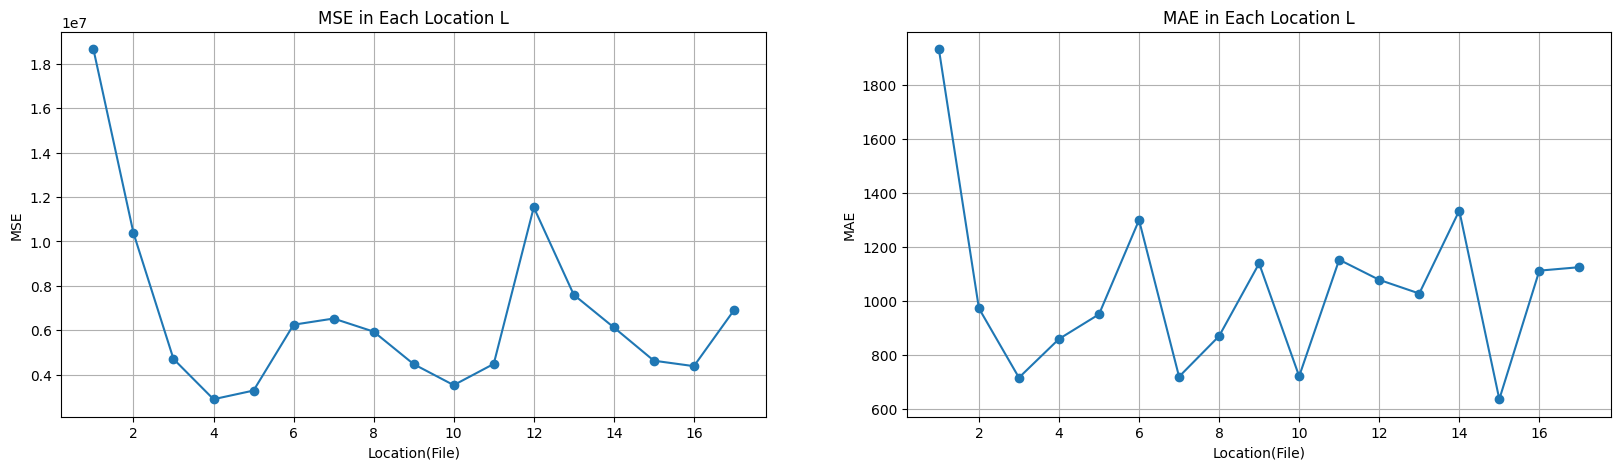

Average MSE:6895427.998229483
Average MAE:1124.147937337191


In [146]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(range(1, len(avg_mse_list) + 1), avg_mse_list, marker='o', linestyle='-')
plt.title("MSE in Each Location L")
plt.xlabel("Location(File)")
plt.ylabel("MSE")
plt.grid()

plt.subplot(122)
plt.plot(range(1, len(avg_mae_list) + 1), avg_mae_list, marker='o', linestyle='-')
plt.title("MAE in Each Location L")
plt.xlabel("Location(File)")
plt.ylabel("MAE")
plt.grid()
plt.show()

plt.show()

avg_mse = np.average(mse_list)
avg_mae = np.average(mae_list)
print(f"Average MSE:{avg_mse}\nAverage MAE:{avg_mae}")

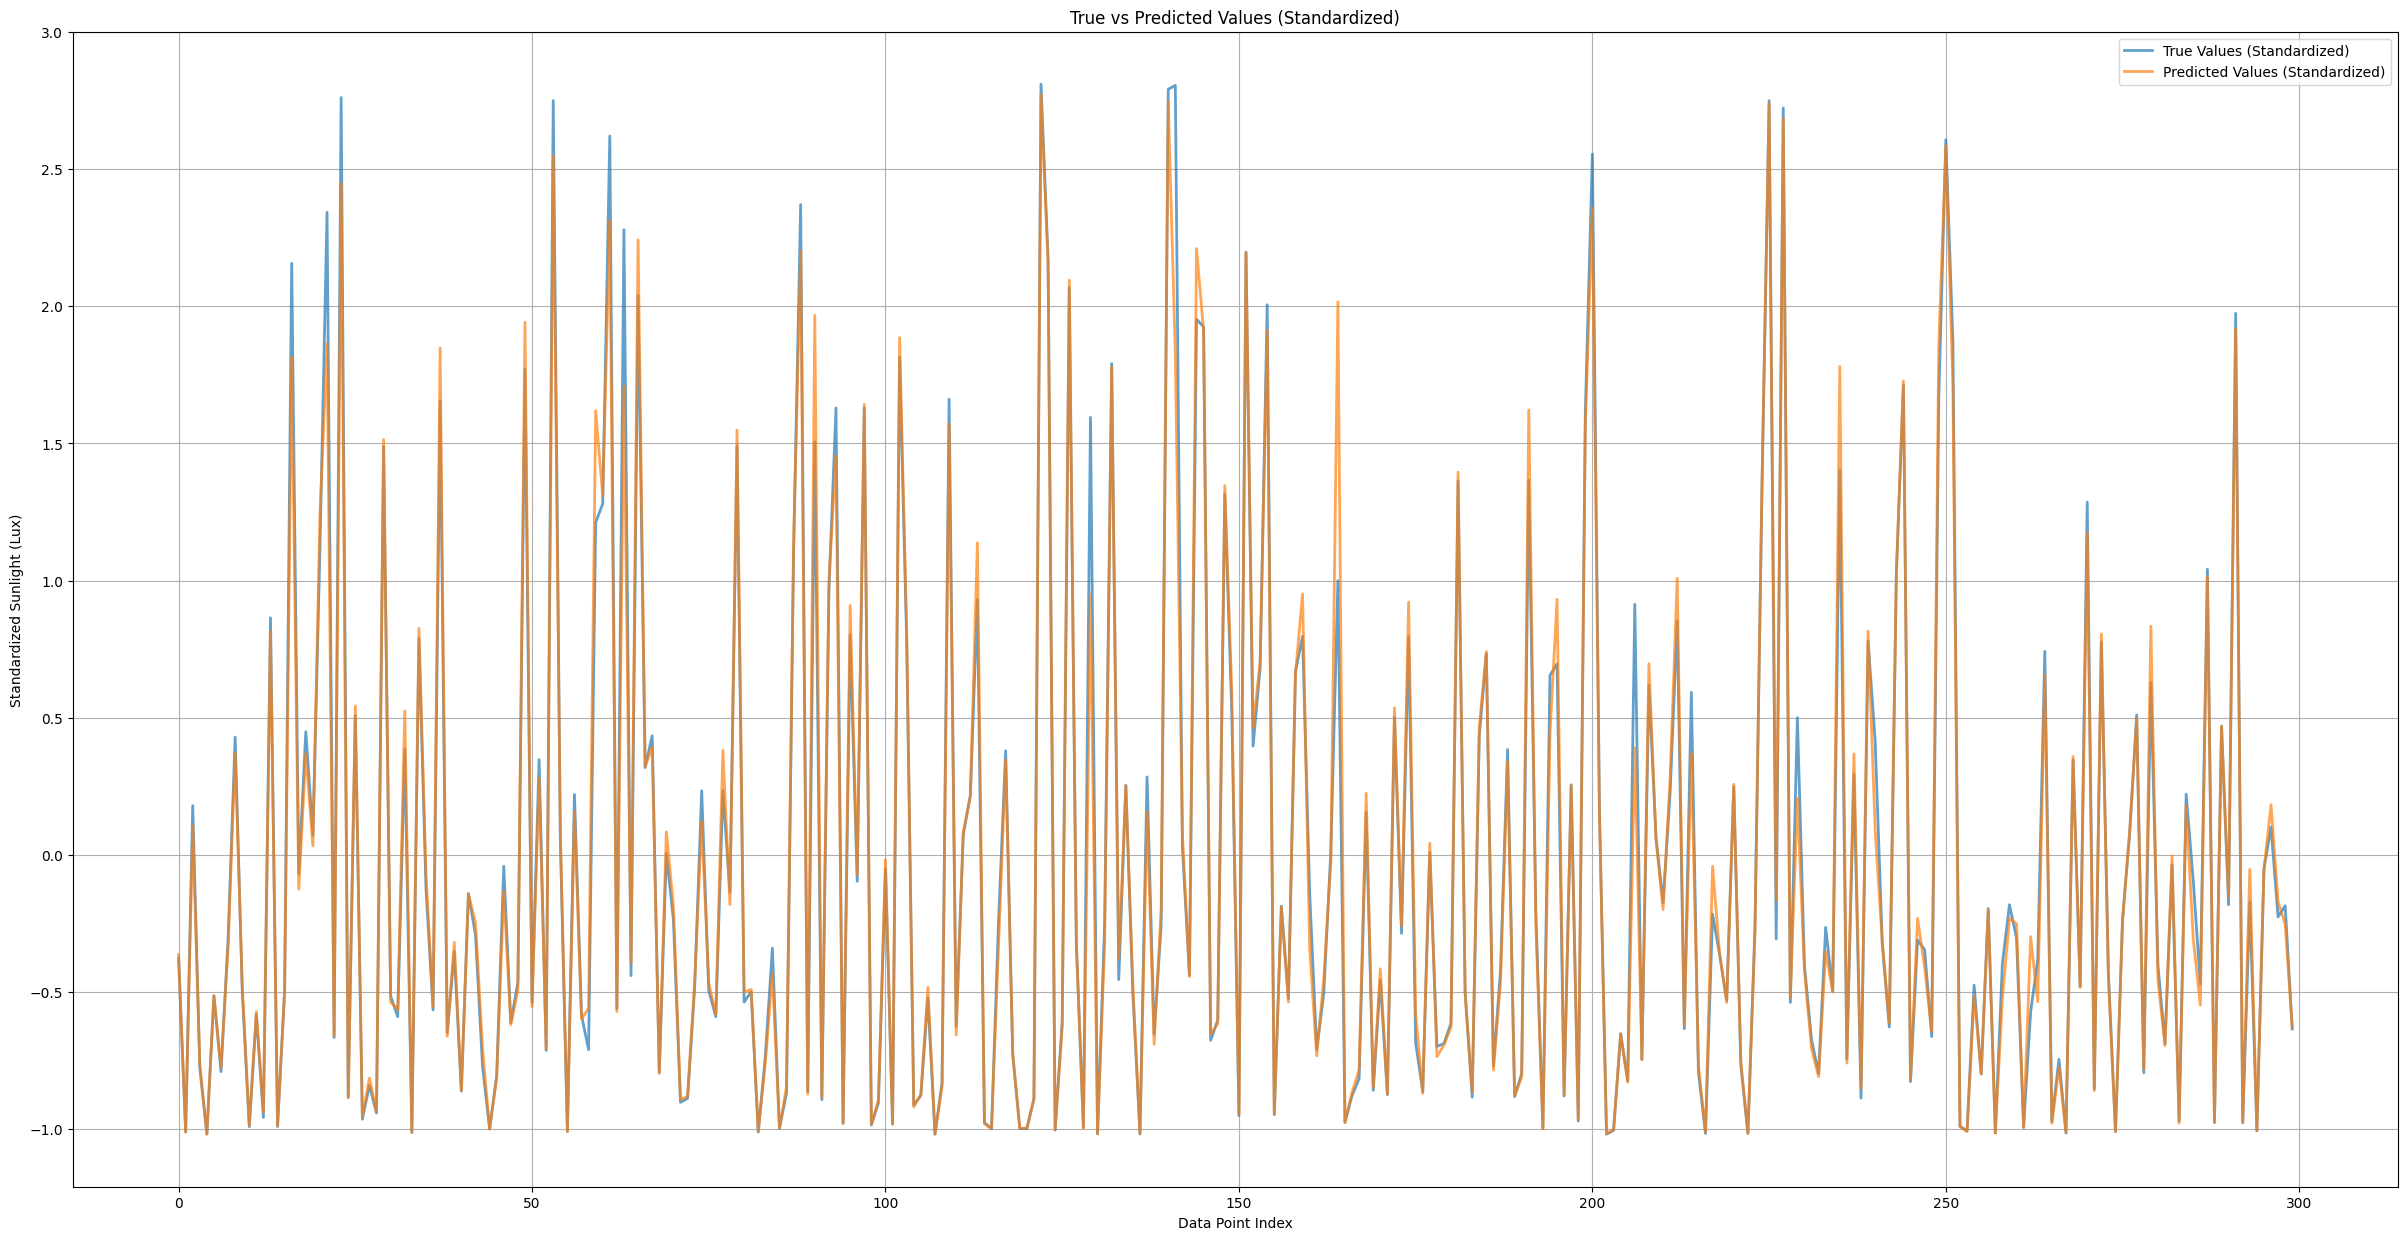

In [147]:
scaler = StandardScaler()

all_true = np.array(all_true[:300]).reshape(-1, 1)
all_pred = np.array(all_pred[:300]).reshape(-1, 1)

all_true_scaled = scaler.fit_transform(all_true)
all_pred_scaled = scaler.transform(all_pred)

# 绘图
plt.figure(figsize=(30, 15))
plt.plot(all_true_scaled, label="True Values (Standardized)", linestyle='-', alpha=0.7, linewidth=2)
plt.plot(all_pred_scaled, label="Predicted Values (Standardized)", linestyle='-', alpha=0.7, linewidth=2)
plt.title("True vs Predicted Values (Standardized)")
plt.xlabel("Data Point Index")
plt.ylabel("Standardized Sunlight (Lux)")
plt.legend()
plt.grid()
plt.show()

## 全部（不採用）
全部資料拿來訓練

In [ ]:
# 存放所有的數據
all_X_train, all_y_train = [], []
all_X_test, all_y_test = [], []


# 讀取並合併數據
for filename in os.listdir(DATA_PATH):
    print(f"Loading data from file: {filename}")
    
    # 載入資料
    filepath = os.path.join(DATA_PATH, filename)
    dataset = LightDataloader(filepath)
    
    # 合併訓練集與測試集
    all_X_train.append(dataset.X_train)
    all_y_train.append(dataset.y_train)
    all_X_test.append(dataset.X_test)
    all_y_test.append(dataset.y_test)

# 將數據拼接到一個大數據集
X_train = np.vstack(all_X_train)
y_train = np.hstack(all_y_train)
X_test = np.vstack(all_X_test)
y_test = np.hstack(all_y_test)

# 建立 DataLoader
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    ),
    batch_size=32,
    shuffle=True,
)

test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    ),
    batch_size=32,
    shuffle=False,
)

# 訓練模型
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# 預測與評估
mse_list = []
mae_list = []
all_true = []
all_pred = []

for batch_X, batch_y in test_loader:
    predictions = reg.predict(batch_X)
    mse = mean_squared_error(batch_y, predictions)
    mse_list.append(mse)

    mae = mean_absolute_error(batch_y, predictions)
    mae_list.append(mae)

    all_true.extend(batch_y.numpy())
    all_pred.extend(predictions)

# 輸出結果
print(f"Overall MSE: {np.mean(mse_list)}")
print(f"Overall MAE: {np.mean(mae_list)}")

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(range(1, len(mse_list) + 1), mse_list, marker='o', linestyle='-')
plt.title("MSE Over Test Batches")
plt.xlabel("Batch Number")
plt.ylabel("MSE")
plt.grid()

plt.subplot(122)
plt.plot(range(1, len(mae_list) + 1), mae_list, marker='o', linestyle='-')
plt.title("MAE Over Test Batches")
plt.xlabel("Batch Number")
plt.ylabel("MAE")
plt.grid()
plt.show()

plt.show()

avg_mse = np.average(mse_list)
avg_mae = np.average(mae_list)
print(f"Average MSE:{avg_mse}\nAverage MAE:{avg_mae}")